# KNN para SalePrice

#### Importar librerías necesarias

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, root_mean_squared_error, r2_score
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#### Carga de datos y preparación de variables

In [59]:
df = pd.read_csv("train.csv")

In [60]:
# Variables predictoras (las mismas que en modelos anteriores)
variables_numericas = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'YearBuilt', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'SalePrice'
]

df = df[variables_numericas]

#### Normalización de datos con logaritmo

In [61]:
df['SalePrice'] = np.log(df['SalePrice'])

#### Definir X (variables predictoras) y "y" (variable respuesta)

In [62]:
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

#### Dividir datos en entrenamienta y prueba

In [63]:
X_train, X_test,y_train, y_test = train_test_split(X, y,test_size=0.3,train_size=0.7,random_state=0)

#### Configurar Pipeline y KNN
##### Escalamos variables numéricas para estandarizar.

In [64]:
numerical_preprocessor = StandardScaler()
preprocessor = ColumnTransformer([
    ('num', numerical_preprocessor, X.columns)
])

In [65]:
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

#### Definición de hiperparámetros para la búsqueda

In [66]:
# Definir hiperparámetros a optimizar en la búsqueda
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18],  # Diferentes valores de k
    'knn__weights': ['uniform', 'distance'],  # Peso de los vecinos
    'knn__p': [1, 2]  # Distancia Manhattan (p=1) vs Euclidiana (p=2)
}

#### Validación Cruzada y GridSearch

In [67]:
# Validación cruzada con 5 folds y GridSearch
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF',
       'FullBath', 'YearBuilt', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces'],
      dtype='object'))])),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

#### Encontrar el mejor modelo 

In [68]:
# Mejor modelo encontrado
best_knn = grid_search.best_estimator_
print(f"Mejor hiperparámetro: {grid_search.best_params_}")


Mejor hiperparámetro: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'}


#### Evaluación del modelo con métricas de regresión

In [69]:
# Evaluación en el conjunto de prueba
y_pred = best_knn.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE en test: {rmse}")
print(f"R² en test: {r2}")

RMSE en test: 0.1617952132948599
R² en test: 0.8305773168743563


#### Scatter plot (valores reales vs. predicciones)

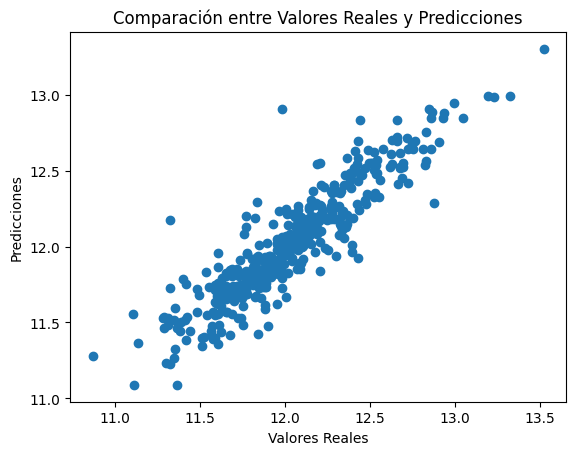

In [70]:
# Visualización de errores
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre Valores Reales y Predicciones")
plt.show()

#### Scatter Plot (valores reales vs. error (residuales))

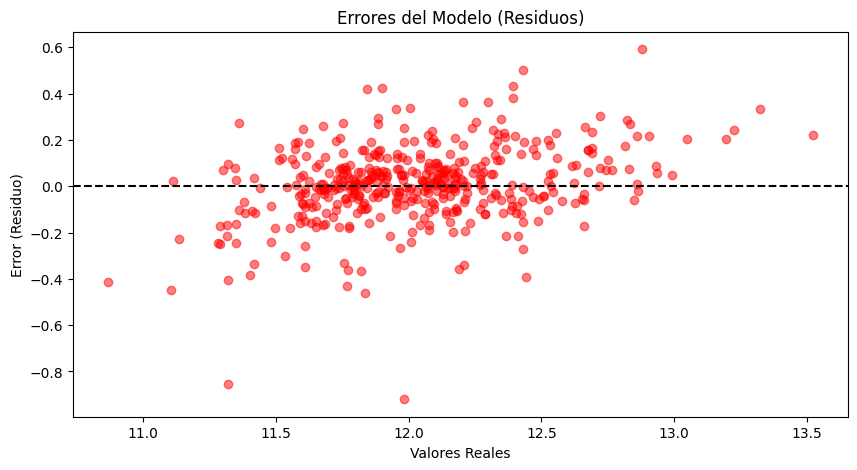

In [71]:
plt.figure(figsize=(10,5))
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Valores Reales")
plt.ylabel("Error (Residuo)")
plt.title("Errores del Modelo (Residuos)")
plt.show()

#### Gráfica de valores reales vs predichos (con índice)

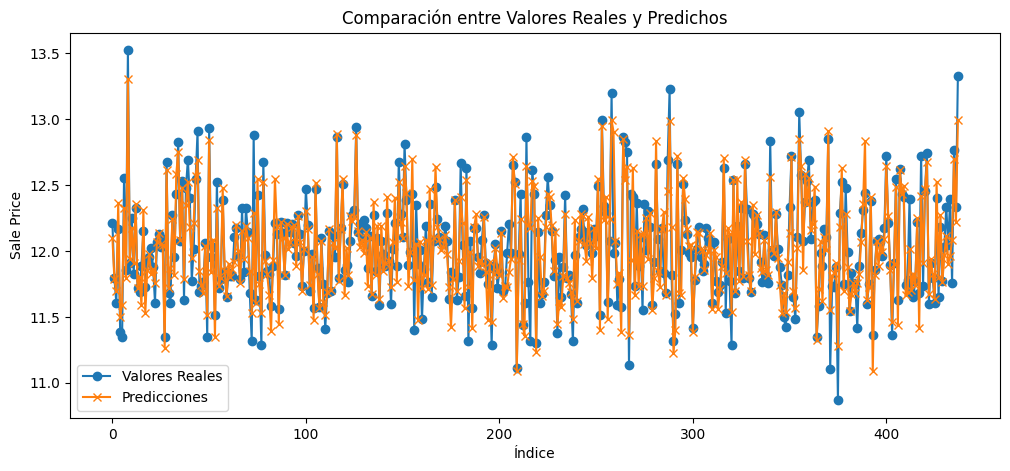

In [72]:
plt.figure(figsize=(12,5))
plt.plot(range(len(y_test)), y_test.values, label="Valores Reales", marker='o')
plt.plot(range(len(y_pred)), y_pred, label="Predicciones", marker='x')
plt.xlabel("Índice")
plt.ylabel("Sale Price")
plt.title("Comparación entre Valores Reales y Predichos")
plt.legend()
plt.show()

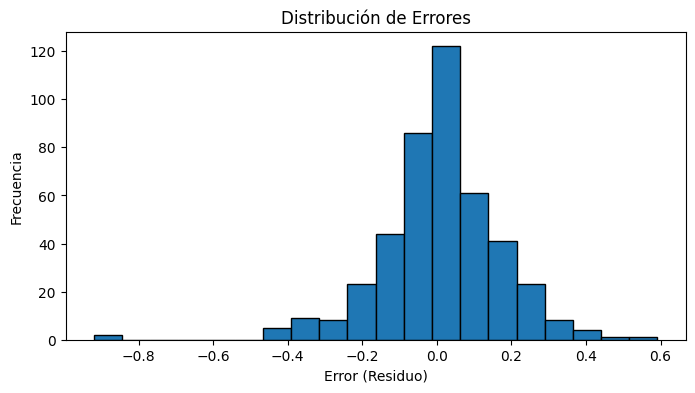

In [73]:
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel("Error (Residuo)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.show()

<small>

# Análisis del Modelo de Regresión con K-Nearest Neighbors (KNN)

---

## 1. Construcción del Modelo y Explicación de Resultados

Para predecir el precio de las casas (`SalePrice`), se construyó un modelo de **K-Nearest Neighbors (KNN)**. Se aseguraron las siguientes condiciones para que el modelo sea **comparativo** con los anteriores:

- Se usaron las mismas variables predictoras que en modelos anteriores.  
- Se aplicó una transformación logarítmica a `SalePrice` para mejorar la distribución de los datos.  
- Se utilizó el **mismo conjunto de entrenamiento y prueba** que en entregas pasadas.  

### **Optimización de Hiperparámetros**
Se realizó una **búsqueda de hiperparámetros** con GridSearchCV para encontrar la mejor combinación de valores de `k`, tipo de peso y distancia utilizada en el cálculo de los vecinos:

- **Mejor hiperparámetro encontrado:**
  - `n_neighbors = 11`
  - `weights = distance`
  - `p = 1` (Distancia Manhattan)

Este modelo optimizado fue evaluado con el conjunto de prueba.

---

## 2. Análisis de Resultados del Modelo KNN

El desempeño del modelo se evaluó con métricas clave:

| **Métrica**  | **Valor**  |
|-------------|-----------|
| **RMSE** (Error cuadrático medio raíz) | 0.1618 |
| **R²** (Varianza explicada) | 0.8306 |

### **Interpretación**
- El **RMSE de 0.1618** indica que el error de predicción promedio del modelo es **relativamente bajo**, considerando que `SalePrice` fue transformado con logaritmo.
- El **R² de 0.83** sugiere que el modelo es capaz de explicar el **83% de la variabilidad en los precios de las casas**, lo que indica un **buen desempeño predictivo**.

### **Visualización de Resultados**
Se generaron diferentes gráficos para analizar el comportamiento del modelo:

1. **Dispersión entre valores reales y predichos:**  
   - Se observa una alineación fuerte con la diagonal, lo que sugiere que el modelo predice bien la mayoría de los valores.  
   
2. **Distribución de Errores:**  
   - La mayoría de los errores están cerca de **0**, lo que indica que el modelo no está sesgado hacia sobre o subestimar los valores.

3. **Gráfico de Residuos:**  
   - La dispersión de los errores no sigue un patrón claro, lo que sugiere que el modelo no presenta problemas graves de heterocedasticidad.

### **Conclusión**
El modelo de **K-Nearest Neighbors (KNN) logró un buen ajuste a los datos**, con una precisión similar a los mejores modelos previos. Sin embargo, será necesario compararlo con **Regresión Lineal, Árbol de Regresión y Naïve Bayes** para determinar cuál es el mejor método de predicción.

---
</small>

# Comparación: Regresión Lineal vs. KNN de regresión

<small>

## Resumen de Métricas

Para determinar cuál modelo funcionó mejor en la predicción de `SalePrice`, se compararon **Regresión Lineal Multivariable, Árbol de Regresión, Naïve Bayes y K-Nearest Neighbors (KNN)** en términos de sus principales métricas de desempeño.

| **Modelo**                 | **R²**  | **RMSE** | **Observaciones Clave** |
|---------------------------|--------|---------|------------------------|
| **Regresión Lineal**      | 0.84   | 0.030   | Mejor desempeño en términos de R². |
| **K-Nearest Neighbors**   | 0.83   | 0.1618  | Buen desempeño, pero sensible al valor de `k`. |

---

## **Análisis Comparativo**

### - **Precisión del Modelo**
- **El modelo de Regresión Lineal Multivariable es el más preciso**, con un **R² de 0.84** y el menor **RMSE de 0.03**.
- **KNN obtiene un R² de 0.83**, lo que lo hace competitivo, pero con un RMSE más alto (0.1618), lo que indica que es más propenso a cometer errores grandes en ciertas predicciones.

### - **Capacidad de Generalización**
- La **Regresión Lineal muestra el mejor equilibrio** entre precisión y generalización, con un R² alto y residuales bien distribuidos.
- **KNN es muy dependiente del número de vecinos (`k`)**, lo que significa que su rendimiento puede variar mucho dependiendo de la elección de hiperparámetros.

---

## **Conclusión - ¿Cuál es el Mejor Modelo?**
- **La Regresión Lineal Multivariable es el modelo con mejor desempeño global.** Explica el **84% de la variabilidad de los precios de las casas** y tiene el **menor error cuadrático medio (RMSE = 0.03)**.
- **KNN mostró un desempeño competitivo (R² = 0.83), pero su RMSE es más alto, lo que indica mayor variabilidad en sus errores.** Puede ser útil en ciertos escenarios, pero requiere un ajuste cuidadoso de `k` para obtener buenos resultados.

### **Recomendación Final**
Si el objetivo es obtener **predicciones precisas y un modelo interpretable**, **la Regresión Lineal Multivariable es la mejor opción**. Sin embargo, si se busca capturar relaciones más complejas, **KNN pueden ser una alternativa viable** con un ajuste adecuado de hiperparámetros.

</small>